Automated methods for comparing transmission line structure LiDAR open the way for a number of opportunities in the identification of trouble areas for designers to focus on. This post will explore an approach for separating structure point cloud clusters, pairing structure point clusters between data sets taken at different times, and comparing cluster pairs using the Hausdorrf distance to determine whether they significantly differ.

<!--excerpt-->

### Import Statements

The following libraries will be used for this post:

* `numpy` - for handling the structure point data in the sample.
* `matplotlib` - used for plotting the data.
* `scikit-learn` - includes the DBSCAN model, which will be used for finding the point clusters for structures.
* `scipy` - includes a KDTree, used for associating point cluster pairs, and the directed Hausdorff function, which is used determine how similar two point clouds are.

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.cluster import DBSCAN
from scipy.spatial import KDTree
from scipy.spatial.distance import directed_hausdorff

### Load Sample Data

The following code loads the sample structure points for this post, which were generated synthetically. The points are grouped into two data sets, A and B.

To simulate characteristics of real LiDAR data, the generated points include variations in insulator rotations, a random outlier point, and a shift in one structure location to simulate a structure replacement.

<IPython.core.display.Javascript object>


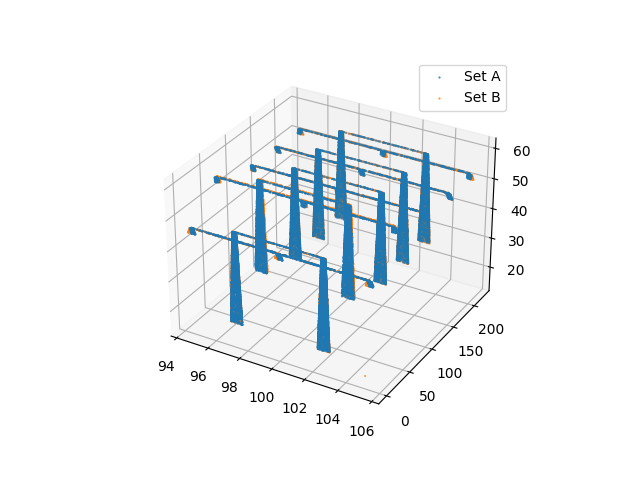

In [2]:
data = np.load("structure_points.npz")
data_a = np.concatenate([data[x] for x in data.files if x.startswith("a")], axis = 0)
data_b = np.concatenate([data[x] for x in data.files if x.startswith("b")], axis = 0)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d")
ax.scatter(data_a[:,0], data_a[:,1], data_a[:,2], marker = ".", s = 1, label = "Set A")
ax.scatter(data_b[:,0], data_b[:,1], data_b[:,2], marker = ".", s = 1, label = "Set B")
ax.legend();

### Find Structure Clusters

The data sets currently include all structure points without any identification between structures. This is how structure LiDAR is often provided. To do any meaningful comparison between the structures, we must first divide these points into separate sets for each structure.

To achieve this, DBSCAN wil be used to find clusters within the point data. Prior to providing the points to the DBSCAN algorithm, however, the points must be normalized to the interval [0, 1]. This may be achieved as follows:

In [3]:
processed_b = data_b - np.min(data_b, axis = 0)
max_value = np.max(processed_b)
processed_b /= max_value

With the data normalized, the points can now be fit to the DBSCAN model. The `eps` parameter, which specifies the threshold in which nearby clusters will be associated with each other, is calculated in this case by specifying a threshold in actual space, then normalizing it to the same interval as the points.

In [4]:
# Calculate eps
threshold = 1.5 # m (~5 ft)
eps = threshold / max_value

model = DBSCAN(eps = eps)
model.fit(processed_b)
labels = sorted(set(model.labels_))
noisy_points = data_b[model.labels_ < 0]

print(f"eps: {eps}")
print(f"Labels: {labels}")
print(f"Noisy Points: {noisy_points}")

eps: 0.006795595057186856
Labels: [-1, 0, 1, 2, 3, 4]
Noisy Points: [[105.   5.  15.]]


In the above results, 6 labels were assigned, with the label -1 corresponding to noisy, dissociated points in the sample. This label corresponds with a single outlier point (105, 5, 15) m.

The identified clusters are plotted below and correspond exactly with the results anticipated for the sample data.

<IPython.core.display.Javascript object>


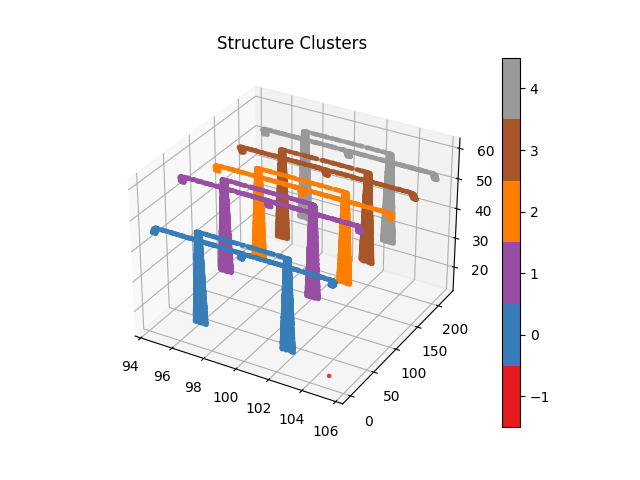

In [5]:
cmap = plt.cm.get_cmap("Set1")
bounds = np.linspace(labels[0] - 0.5, labels[-1] + 0.5, len(labels) + 1)
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure()
ax = fig.add_subplot(projection = "3d", title = "Structure Clusters")
scatter = ax.scatter(data_b[:,0], data_b[:,1], data_b[:,2],
                     s = 5,
                     c = model.labels_,
                     norm = norm,
                     cmap = cmap)

fig.colorbar(scatter, ticks = labels);

### Associating Structure Clusters

Now that the individual structure clusters have been identified, we need to begin to break them into pairs so that the point clouds can be compared to see if there are any changes for that structure. One way to accomplish this is to calculate the centers for each structure, via the mean, then simply assign pairs based on the nearest points between the two data sets.

Distances that exceeed a cetain threshold may also be used to throw out associations. Such cases likely indicate that either a new structure has been added or an existing structure has been removed between the data sets.

The structure centers for each data set are calculated below. A KDTree is then used to determine the nearest points between data sets. For the purpose of this example, the centers for Set A are simply calculated based on the known structure clusters. However, in practice, these would instead be calculated based on the clustering model results, as is done with Set B.

In [6]:
centers_a = np.array([np.mean(data[f"a{i}"], axis = 0) for i in range(1, 6)])
centers_b = np.array([np.mean(data_b[model.labels_ == x], axis = 0) for x in labels if x >= 0])

tree = KDTree(centers_a)
query = tree.query(centers_b)
print(f"Distances: {query[0]} m")
print(f"Indexes: {query[1]}")

Distances: [0.08620595 1.5151521  0.40476159 0.04394326 0.17809659] m
Indexes: [0 1 2 3 4]


### Compare Structures

Now that the structure points have been clustered and associated into pairs, we can begin to compare the associated clusters to determine whether their point clouds are similar. For this post, let us look as the first structure as an example, which is plotted below.

<IPython.core.display.Javascript object>


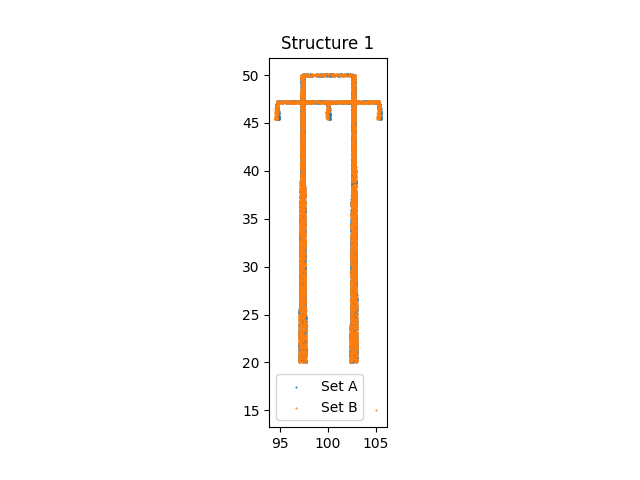

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, title = "Structure 1", aspect = "equal")
ax.scatter(data["a1"][:,0], data["a1"][:,2], marker = ".", s = 1, label = "Set A")
ax.scatter(data["b1"][:,0], data["b1"][:,2], marker = ".", s = 1, label = "Set B")
ax.legend();

To guage the similarity between the structure points, the [Hausdorrf distance](https://en.wikipedia.org/wiki/Hausdorff_distance) will be calculated between the point clouds for this structure in Set A and B. If this distance is smaller than a specified acceptance threshold, then we will conclude than they are similar.

In [8]:
haus_ab = directed_hausdorff(data["a1"], data["b1"])
haus_ba = directed_hausdorff(data["b1"], data["a1"])
haus_dist = max(haus_ab[0], haus_ba[0])
print(f"Hausdorff Distance: {haus_dist:0.4} m")

Hausdorff Distance: 7.277 m


From the above result, the point clouds appear to be quite different. Looking at the data further, this is caused by an outlier point, which can be seen in the bottom right of the structure plot. To remove this point, the interquartile range (IQR) can be used, as follows:

In [9]:
q1 = np.percentile(data["b1"], 25, axis = 0) # First quartile
q3 = np.percentile(data["b1"], 75, axis = 0) # Third quartile
iqr = q3 - q1 # Interquartile range

# Outlier bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1: {q1} m")
print(f"Q3: {q3} m")
print(f"IQR: {iqr} m")

# Boolean array identifying outliers
lower_outliers = np.any(data["b1"] < lower_bound, axis = 1)
upper_outliers = np.any(data["b1"] > upper_bound, axis = 1)
outliers = lower_outliers | upper_outliers

print(f"Outlier Count: {outliers.sum()}")

Q1: [97.330275   -0.12839261 28.65708995] m
Q3: [102.65379548   0.17898731  45.76638222] m
IQR: [ 5.32352048  0.30737991 17.10929227] m
Outlier Count: 1


Filtering out the outlier, the new Hausdorff distance is calculated below. The Hausdorff distance is relatively small, indicating that the structure point clouds are likely similar.

In [10]:
haus_ab = directed_hausdorff(data["a1"], data["b1"][~outliers])
haus_ba = directed_hausdorff(data["b1"][~outliers], data["a1"])
haus_dist = max(haus_ab[0], haus_ba[0])

similarity_limit = 0.6069 # m (2 ft)
print(f"Hausdorff Distance: {haus_dist:0.4} m")
print(f"Structures Are Similar: {haus_dist <= similarity_limit}")

Hausdorff Distance: 0.2855 m
Structures Are Similar: True


### Conclusion

The above approach can be used to compare structure point clouds between two sets of LiDAR. Using this approach, changes that have occured between different surveys could be identified through automation. Furthermore, structures which have been downed or significantly damaged during storms could be quickly identified and flagged for early response. Implementing a similar approach using model data for one data set could also allow automated difference evaluations with as-built survey.